# 

# Combination of Two Machine Learning Models

1. [Libraries and Data Loading](#1)
2. [Statistics](#2)
3. [Feature Selection](#3)
4. [Feature Extration](#4)
5. [Processing Supervised model ANN and SVM](#5)
6. [Looping between the features](#6)
7. [Plottings](#7)


## <a id="1">1. Libraries and Data Loading</a>
Pandas is managed to read the xlsx file and create two dataframes: one for traning and another for testing.<br>
All sheets from traning data are merged into one dataframe and then transformed to a spark dataframe.<br>
Similar, all sheets from test data are merged into one dataframe and then transformed to a spark dataframe.

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA as skPCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import pandas as pandi
import matplotlib.pyplot as plt
import seaborn as seab
import plotly.express as ploti
import numpy as numpi
import warnings

pandi.set_option('display.width', 1500) #Increasing the display output width

2023-10-31 18:08:37.216249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 18:08:37.535762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 18:08:37.535805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 18:08:37.537511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 18:08:37.710463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 18:08:37.712843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
warnings.filterwarnings('ignore')

# Loading XLSX file into Pandas to create one dataframe concatenating the sheets from Train-1 to Train-10
df_training = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Train-1', 'Train-2', 'Train-3', 'Train-4', 'Train-5', 'Train-6', 'Train-7', 'Train-8', 'Train-9', 'Train-10'])
df_training = pandi.concat(df_training.values(), ignore_index=True)

# Loading XLSX file into Pandas with the sheets from Test-1 to Test-5
df_testing = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5'])
# df_testing = pandi.concat(df_testing.values(), ignore_index=True)

# Printing Columns
print('\nColumn names:\n')
print(df_training.columns.tolist())
print(df_training.head(2))
print(f'Training dataset shape: {df_training.shape}')
print(f'Testing dataset shape: {df_testing["Test-1"].shape}')


Column names:

['BIS', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
    BIS        x1        x2        x3        x4        x5        x6        x7        x8
0  90.2  0.689160  3.643863  1.789239  1.778735  0.656469  0.385934  1.031026  1.790311
1  90.2  0.704845  3.636994  1.780926  1.778575  0.661085  0.388855  1.031065  1.790393
Training dataset shape: (27452, 9)
Testing dataset shape: (2905, 9)


## <a id="2">2. Statistics</a>

              x1         x2         x3         x4         x5         x6         x7         x8
count  27452.000  27452.000  27452.000  27452.000  27452.000  27452.000  27452.000  27452.000
mean       0.781      0.969      1.785      1.789      0.675      0.388      1.015      1.785
std        0.306      0.969      0.003      0.009      0.048      0.009      0.025      0.005
min        0.045      0.191      1.779      1.542      0.535      0.374      0.881      1.766
25%        0.556      0.401      1.782      1.790      0.639      0.382      1.006      1.782
50%        0.761      0.557      1.785      1.791      0.677      0.385      1.015      1.785
75%        1.021      1.215      1.788      1.791      0.714      0.389      1.024      1.789
max        1.954      6.806      1.791      1.792      0.836      0.445      1.138      1.792


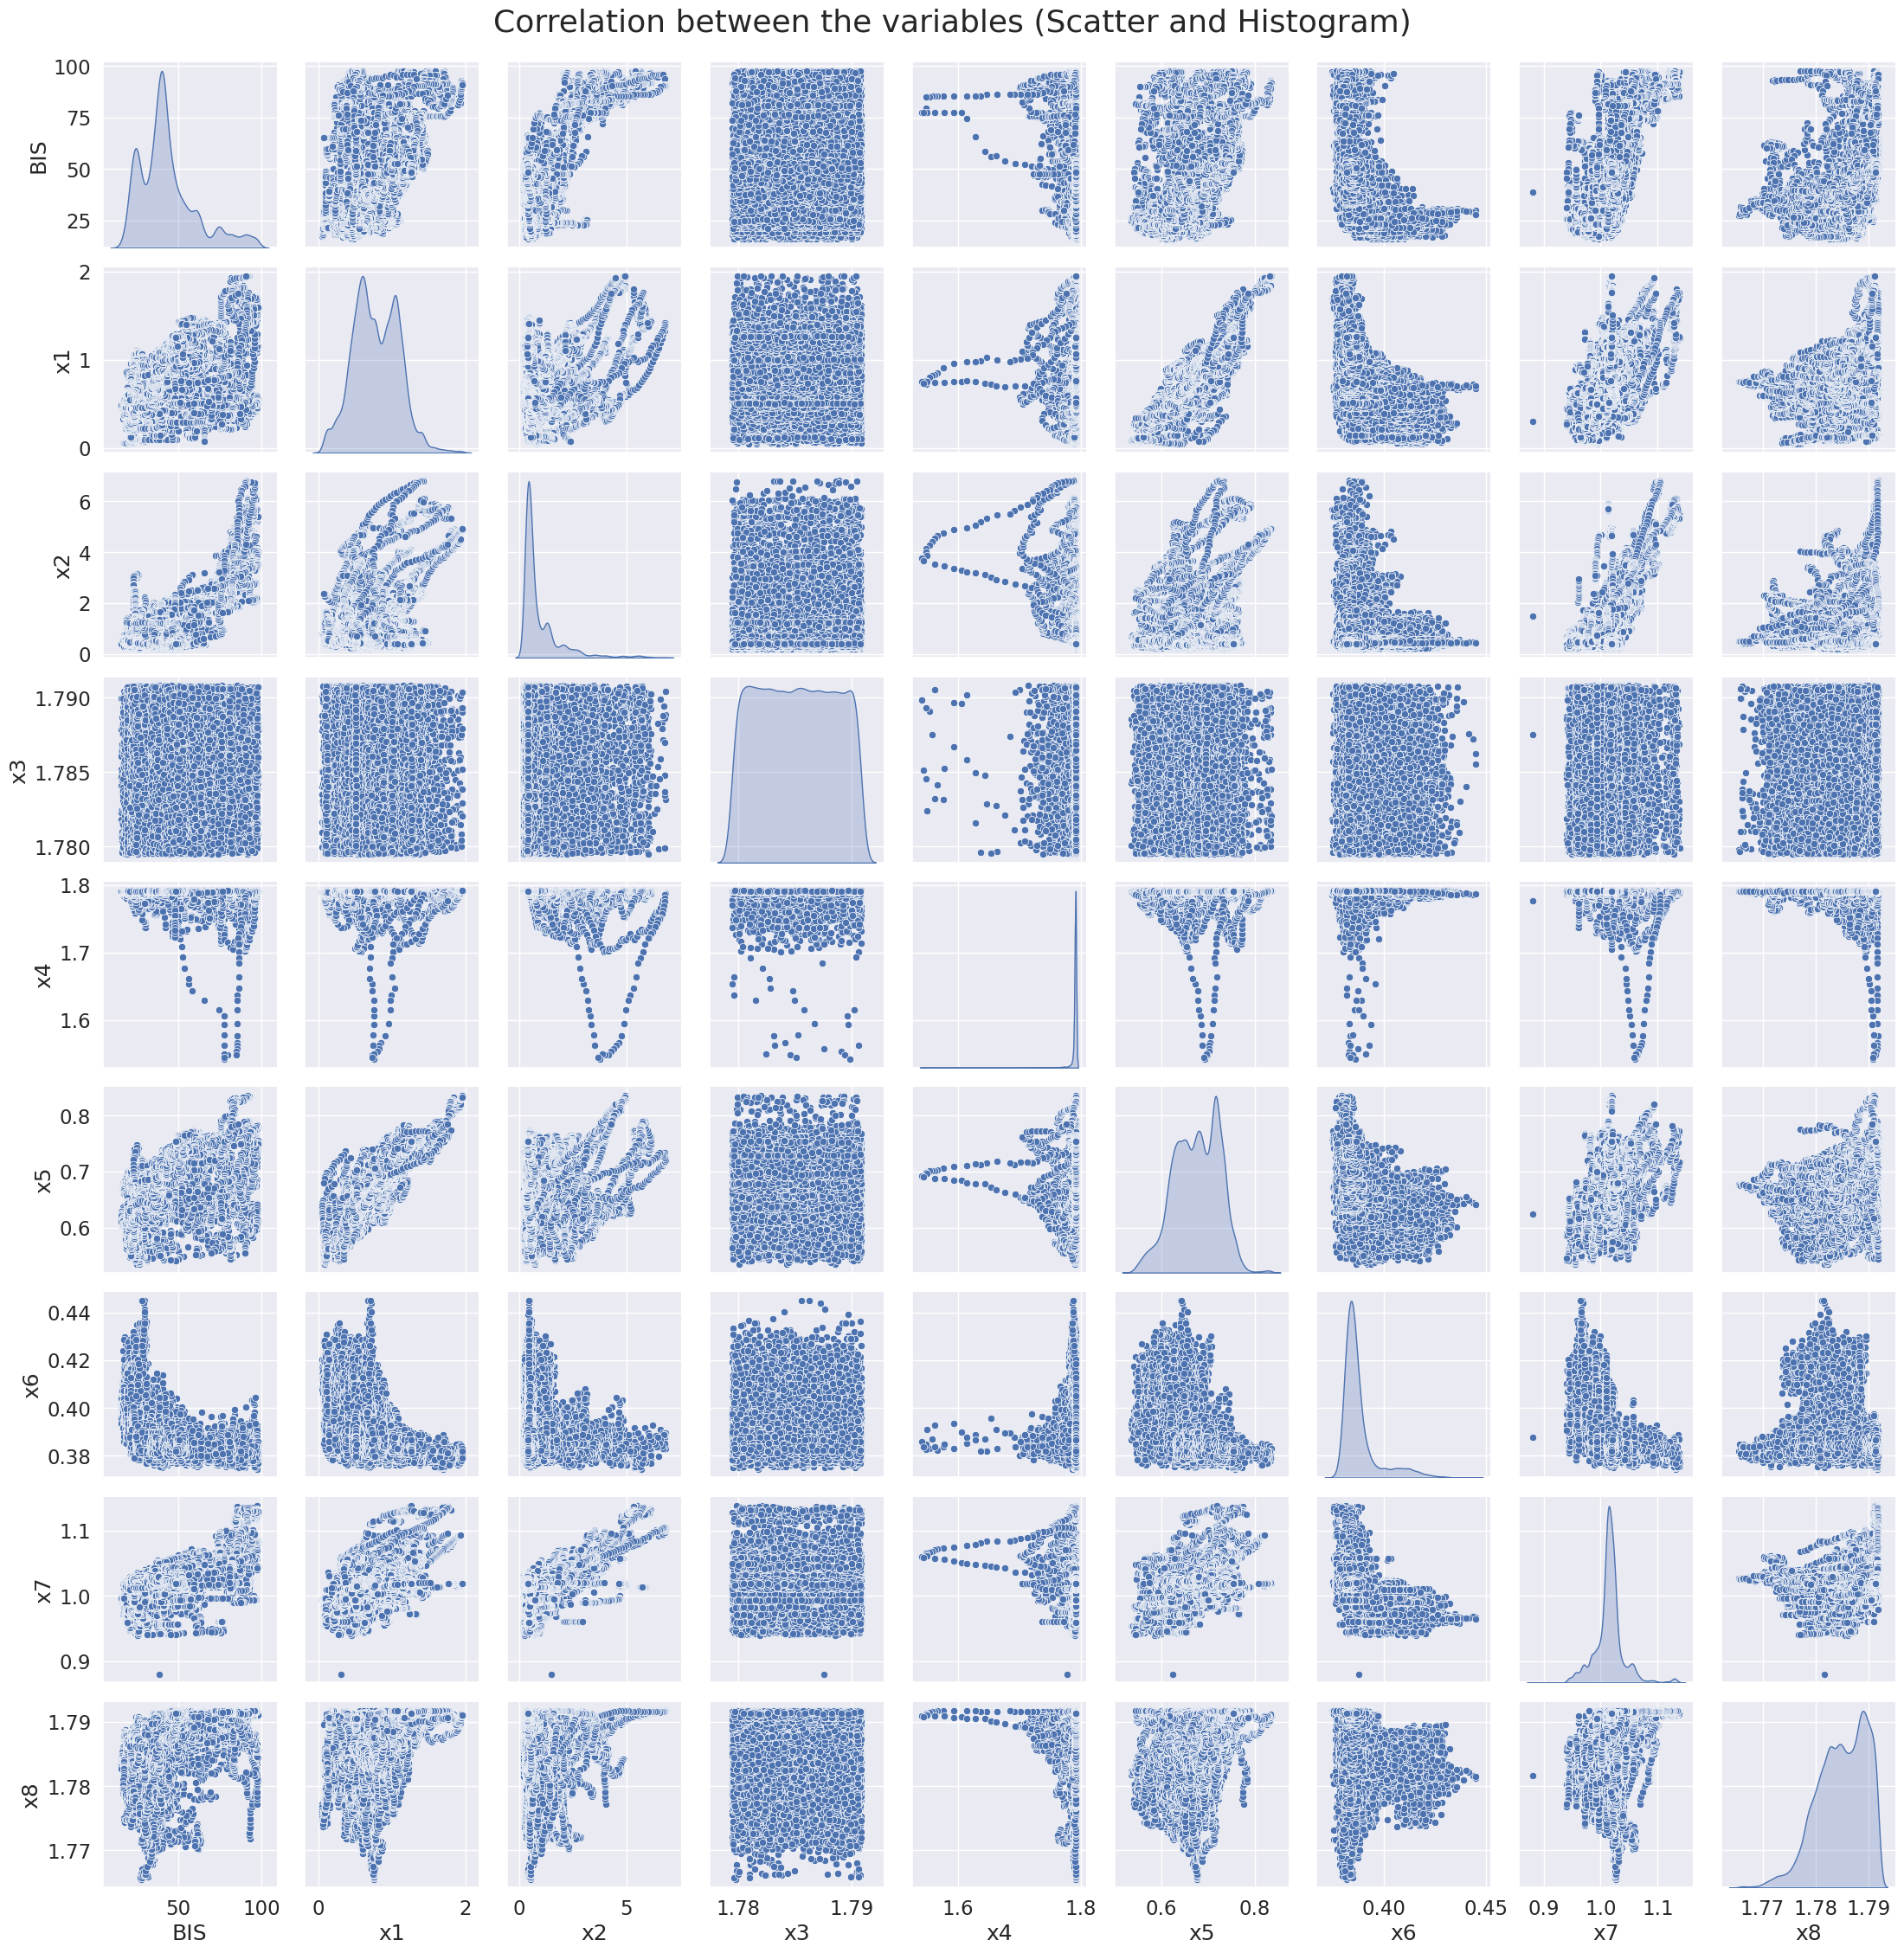

       BIS     x1     x2     x3     x4     x5     x6     x7     x8
BIS  1.000  0.474  0.744  0.008 -0.233  0.458 -0.490  0.643  0.451
x1   0.474  1.000  0.255  0.005  0.035  0.902 -0.475  0.469  0.342
x2   0.744  0.255  1.000  0.011 -0.330  0.190 -0.174  0.608  0.284
x3   0.008  0.005  0.011  1.000 -0.006  0.007  0.002  0.009  0.011
x4  -0.233  0.035 -0.330 -0.006  1.000  0.038  0.005 -0.130 -0.095
x5   0.458  0.902  0.190  0.007  0.038  1.000 -0.469  0.420  0.340
x6  -0.490 -0.475 -0.174  0.002  0.005 -0.469  1.000 -0.539 -0.116
x7   0.643  0.469  0.608  0.009 -0.130  0.420 -0.539  1.000  0.173
x8   0.451  0.342  0.284  0.011 -0.095  0.340 -0.116  0.173  1.000


In [49]:
## Generating basic statistics
print(df_training.drop('BIS', axis=1).describe().round(3))
# df_training.drop('BIS', axis=1).describe().round(3).to_excel('./data/descriptive_statistics.xlsx')

# Visual correlation between variables using parplot from seaborn
# Increae the fontsize of the axis
seab.set(font_scale=1.5)
seab.pairplot(df_training, diag_kind='kde')
plt.suptitle('Correlation between the variables (Scatter and Histogram)', fontsize=26, y=1.01)
plt.show()

## Generating the Correlation Matrix (Pearson Coefficient)
personCorrM = df_training.corr(method='pearson').round(3)
print(personCorrM)

heatmap_mask = numpi.triu(numpi.ones_like(df_training.corr(method='pearson'), dtype=bool))
heatmap_mask_cm = personCorrM.mask(heatmap_mask)

ploti_fig = ploti.imshow(heatmap_mask_cm,
                        color_continuous_scale='rdylgn',
                        text_auto=True,
                        width=700, height=700,
                        zmin=-1, zmax=1,
                        title='Correlation Matrix')
ploti_fig.show()


## <a id="3">3. Feature Selection</a>

In [27]:
## Feature Selection using Correlation Matrix (Pearson Coefficient)
# Selecting the features with correlation coefficient higher than 0.5
corr_threshold = 0.5
df_training_corr = personCorrM.drop('BIS', axis=0).drop('BIS', axis=1)
df_training_corr = df_training_corr[df_training_corr > corr_threshold].dropna(axis=0, how='all').dropna(axis=1, how='all').mask(df_training_corr == 1.0)
df_training_corr = df_training_corr.stack().reset_index()
df_training_corr.columns = ['Features 1', 'Features 2', 'Correlation Coefficient']
print('\nFeatures selected by the Correlation Matrix:\n')
print(df_training_corr)



## Univariate Feature Selection
# Before applying the Univariate Feature Selection, we need to discretise the target variable (BIS)
# So, the target variable (BIS) is discretised into 5000 bins
discretiser = KBinsDiscretizer(n_bins=27452, encode='ordinal', strategy='uniform')
df_training_discretised = discretiser.fit_transform(df_training['BIS'].values.reshape(-1, 1))
df_training_discretised = df_training_discretised.ravel()

# Select the top 4 features with the highest ChiSqSelector score
selectkbest = SelectKBest(score_func=chi2, k=4)
selectkbest.fit(df_training.drop('BIS', axis=1), df_training_discretised)
df_training_univ = selectkbest.transform(df_training.drop('BIS', axis=1))
df_training_univ_names = df_training.drop('BIS', axis=1).columns.values[selectkbest.get_support()]
df_training_univ_fs = pandi.DataFrame(df_training_univ, columns=df_training_univ_names)
print('\nFeatures selected by using Univariate :\n')
print(df_training_univ_fs.head(2))
df_training_univ_fs_col = df_training_univ_fs.columns
print(df_training_univ_fs_col.tolist())



Features selected by the Correlation Matrix:

  Features 1 Features 2  Correlation Coefficient
0         x1         x5                    0.902
1         x2         x7                    0.608
2         x5         x1                    0.902
3         x7         x2                    0.608

Features selected by using Univariate :

         x1        x2        x5        x7
0  0.689160  3.643863  0.656469  1.031026
1  0.704845  3.636994  0.661085  1.031065
['x1', 'x2', 'x5', 'x7']


## <a id="4">4. Feature Extration</a>

In [7]:
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']

## Independent Component Analysis ICA from Sklearn
# Training dataset from ICA features
ica_array_features = []
for n_components in range(2, 9):
    ica = FastICA(n_components=n_components, random_state=0)
    ica = ica.fit(df_training.drop('BIS', axis=1))

    ica_array_features.append(pandi.DataFrame(ica.transform(df_training.drop('BIS', axis=1)), columns=ica.get_feature_names_out().tolist()))
    print(f'ICA - Training Features with {n_components} components:\n{ica_array_features[n_components - 2].columns.tolist()}\n')

# Testing dataset from ICA features
# the object ica_array_features_test is an object that contains the features from the testing dataset
# It is organised as a dictionary with the key as the name of the test dataset and the value as the features
# But every test dataset has different number of features, so the key is the name of the test dataset and the number of components
# Example: Test-1_2 means that the test dataset is Test-1 and the number of components is 2
# Test-1_3 means that the test dataset is Test-1 and the number of components is 3
# and so on...
ica_array_features_test = {}
for idx, test in enumerate(test_datasets):
    for n_components in range(2, 9):
        ica = FastICA(n_components=n_components, random_state=0)
        ica = ica.fit(df_testing[test].drop('BIS', axis=1))
        ica_array_features_test[f'{test}_{n_components}'] = pandi.DataFrame(ica.transform(df_testing[test].drop('BIS', axis=1)), columns=ica.get_feature_names_out().tolist())
        columns = ica_array_features_test[f'{test}_{n_components}'].columns.tolist()
        print(f'ICA - Testing Features for {test} components {n_components}:\n{columns}\n')

## Principal Component Analysis PCA from Sklearn
# Training dataset from PCA features
pca_array_features = []
for n_components in range(2, 9):
    pca = skPCA(n_components=n_components)
    pca = pca.fit(df_training.drop('BIS', axis=1))
    pca_array_features.append(pandi.DataFrame(pca.transform(df_training.drop('BIS', axis=1)), columns=pca.get_feature_names_out().tolist()))
    print(f'PCA - Training Features with {n_components} components:\n{pca_array_features[n_components - 2].columns.tolist()}\n')

# Testing dataset from PCA features
# the object pca_array_features_test is an object that contains the features from the testing dataset
# It is organised as a dictionary with the key as the name of the test dataset and the value as the features
# But every test dataset has different number of features, so the key is the name of the test dataset and the number of components
# Example: Test-1_2 means that the test dataset is Test-1 and the number of components is 2
# Test-1_3 means that the test dataset is Test-1 and the number of components is 3
# and so on...
pca_array_features_test = {}
for idx, test in enumerate(test_datasets):
    for n_components in range(2, 9):
        pca = skPCA(n_components=n_components)
        pca = pca.fit(df_testing[test].drop('BIS', axis=1))
        pca_array_features_test[f'{test}_{n_components}'] = pandi.DataFrame(pca.transform(df_testing[test].drop('BIS', axis=1)), columns=pca.get_feature_names_out().tolist())
        columns = pca_array_features_test[f'{test}_{n_components}'].columns.tolist()
        print(f'PCA - Testing Features for {test} components {n_components}:\n{columns}\n')

    

ICA - Training Features with 2 components:
['fastica0', 'fastica1']

ICA - Training Features with 3 components:
['fastica0', 'fastica1', 'fastica2']

ICA - Training Features with 4 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3']

ICA - Training Features with 5 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4']

ICA - Training Features with 6 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5']

ICA - Training Features with 7 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5', 'fastica6']

ICA - Training Features with 8 components:
['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4', 'fastica5', 'fastica6', 'fastica7']

ICA - Testing Features for Test-1 components 2:
['fastica0', 'fastica1']

ICA - Testing Features for Test-1 components 3:
['fastica0', 'fastica1', 'fastica2']

ICA - Testing Features for Test-1 components 4:
['fastica0', 'fastica1', 'fastica2', 'fastica3']

ICA - T

# <a id="5">5. Processing the models: ANN -> SVM</a>

In [53]:

## Combined Models

# train_labels = df_training['BIS']
# test_features = df_testing['Test-1'].drop('BIS', axis=1)[df_training_univ_fs_col]
def combined_ML(test, train_features, test_features, train_labels, test_labels, method, plotting = False):

    data_analysis = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])

    dimention_input = train_features.shape[1]

    first_h_layer = 6
    second_h_layer = 12

    ann_model = Sequential()
    ann_model.add(Dense(first_h_layer, input_dim=dimention_input, activation='tanh'))
    ann_model.add(Dense(second_h_layer, activation='tanh'))
    ann_model.add(Dense(1, activation='linear'))

    # Compiling the ANN model
    ann_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    # Fitting the ANN model
    print('\nFitting ANN model...')
    ann_model.fit(train_features, train_labels, epochs=25, batch_size=10, verbose=0)

    # Extracting the new train_features for the SVM from the hidden layers
    hidden_layers = ann_model.layers[1:-1]
    features_hidden_layer_model = Model(inputs=ann_model.input, outputs=[ly.output for ly in hidden_layers])
    # features_hidden_layer_model = Model(inputs=ann_model.input, outputs=ann_model.layers[1].output)

    # Predicting with the hidden layers to use the results as train_features for the SVM
    features_hidden_layer = features_hidden_layer_model.predict(train_features)

    ## TRAINING THE SVM MODEL
    # Connect the new model to SVM
    svm_model = svm.SVR(kernel='rbf', C=50, gamma=0.1, epsilon=.1)
    print('\nFitting SVM model...')
    svm_model.fit(features_hidden_layer, train_labels)

    ## TESTING THE SVM MODEL
    # Predicting first with the ANN model
    features_hidden_layer = features_hidden_layer_model.predict(test_features)
    # Predicting with the SVM model
    pd_svm = pandi.DataFrame(svm_model.predict(features_hidden_layer), columns=['newBIS'])
    # statistics
    coef, pv = pearsonr(test_labels.ravel(), pd_svm['newBIS'].ravel())
    new_row = {'Test': test,
                'Method': method, 
                'Features': train_features.columns.tolist(), 
                'ANN_first_h_layer': first_h_layer, 
                'ANN_second_h_layer': second_h_layer, 
                'Pearson': coef, 
                'MSE': mean_squared_error(test_labels, pd_svm['newBIS']),
                'MAE': mean_absolute_error(test_labels, pd_svm['newBIS']),
                'R2': r2_score(test_labels, pd_svm['newBIS'])
                }
    
    data_analysis = pandi.concat([data_analysis, pandi.DataFrame(new_row)], ignore_index=True)
    print(new_row)
    
    if plotting:
        # plot predictions and expected results
        plt.plot(test_labels, label=f'{test} - Expected', color='red')
        plt.plot(pd_svm['newBIS'], label=f'New DoA - Predicted', color='blue')
        plt.title(f'{test} - Predicted vs Expected')
        plt.xlabel(f'Time\nPearson: {coef:.3f}')
        plt.ylabel('BIS')
        plt.legend()
        plt.show()
        
    return data_analysis


## <a id="6">6. Looping between the features</a>

In [47]:
# ## Uivariate Feature Selection
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']

data_analysis_univ = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
for test in test_datasets:
    stat_comb_ml = combined_ML(test, df_training_univ_fs, df_testing[test].drop('BIS', axis=1)[df_training_univ_fs_col.tolist()], df_training['BIS'], df_testing[test]['BIS'], 'Univariate')
    data_analysis_univ = pandi.concat([data_analysis_univ, stat_comb_ml], ignore_index=True)

display(data_analysis_univ.to_string())
data_analysis_univ.to_excel(f'./data/data_analysis_univ.xlsx', index=False)

## ICA Feature Selection
data_analysis_ica = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
for index_test, test in enumerate(test_datasets):
    for index_features, ica_features in enumerate(ica_array_features):
        columns = ica_array_features_test[f'{test}_{index_features + 2}'].columns.tolist()
        print(f'index: {index_features} - test: {test} - columns of feature test: {columns}')
        stat_comb_ml = combined_ML(test, ica_features, ica_array_features_test[f'{test}_{index_features + 2}'], df_training['BIS'], df_testing[test]['BIS'], 'ICA')
        data_analysis_ica = pandi.concat([data_analysis_ica, stat_comb_ml], ignore_index=True)

display(data_analysis_ica.to_string())
data_analysis_ica.to_excel(f'./data/data_analysis_ica.xlsx', index=False)

## PCA Feature Selection
data_analysis_pca = pandi.DataFrame(columns=['Test', 'Method', 'Features', 'ANN_first_h_layer', 'ANN_second_h_layer', 'ANN_second_h_layer', 'Pearson', 'MSE', 'MAE', 'R2'])
for index_test, test in enumerate(test_datasets):
    for index_features, pca_features in enumerate(pca_array_features):
        columns = pca_array_features_test[f'{test}_{index_features + 2}'].columns.tolist()
        print(f'index: {index_features} - test: {test} - columns of feature test: {columns}')
        stat_comb_ml = combined_ML(test, pca_features, pca_array_features_test[f'{test}_{index_features + 2}'], df_training['BIS'], df_testing[test]['BIS'], 'PCA')
        data_analysis_pca = pandi.concat([data_analysis_pca, stat_comb_ml], ignore_index=True)

display(data_analysis_pca.to_string())
data_analysis_pca.to_excel(f'./data/data_analysis_pca.xlsx', index=False)



Fitting ANN model...
858/858 [==============================] - 1s 993us/step

Fitting SVM model...
91/91 [==============================] - 0s 688us/step
{'Test': 'Test-1', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8649900711534022, 'MSE': 88.39382849153547, 'MAE': 7.055409526351478, 'R2': 0.7180017180722792}

Fitting ANN model...
858/858 [==============================] - 1s 872us/step

Fitting SVM model...
86/86 [==============================] - 0s 880us/step
{'Test': 'Test-2', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8792897280228643, 'MSE': 74.08352181090781, 'MAE': 6.363787590922336, 'R2': 0.6472700374820866}

Fitting ANN model...
858/858 [==============================] - 1s 968us/step

Fitting SVM model...
107/107 [==============================] - 0s 912us/step
{'Test': 'Test-3', 'Method': 'Univariate', 'Featur

'      Test      Method Features ANN_first_h_layer ANN_second_h_layer   Pearson         MSE       MAE        R2\n0   Test-1  Univariate       x1                 6                 12  0.864990   88.393828  7.055410  0.718002\n1   Test-1  Univariate       x2                 6                 12  0.864990   88.393828  7.055410  0.718002\n2   Test-1  Univariate       x5                 6                 12  0.864990   88.393828  7.055410  0.718002\n3   Test-1  Univariate       x7                 6                 12  0.864990   88.393828  7.055410  0.718002\n4   Test-2  Univariate       x1                 6                 12  0.879290   74.083522  6.363788  0.647270\n5   Test-2  Univariate       x2                 6                 12  0.879290   74.083522  6.363788  0.647270\n6   Test-2  Univariate       x5                 6                 12  0.879290   74.083522  6.363788  0.647270\n7   Test-2  Univariate       x7                 6                 12  0.879290   74.083522  6.363788  0

index: 0 - test: Test-1 - columns of feature test: ['fastica0', 'fastica1']

Fitting ANN model...
858/858 [==============================] - 1s 706us/step

Fitting SVM model...
91/91 [==============================] - 0s 936us/step
{'Test': 'Test-1', 'Method': 'ICA', 'Features': ['fastica0', 'fastica1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.3530444680580205, 'MSE': 401.1113721154697, 'MAE': 14.381414926226732, 'R2': -0.2796449676242354}
index: 1 - test: Test-1 - columns of feature test: ['fastica0', 'fastica1', 'fastica2']

Fitting ANN model...
858/858 [==============================] - 1s 1ms/step

Fitting SVM model...
91/91 [==============================] - 0s 1ms/step
{'Test': 'Test-1', 'Method': 'ICA', 'Features': ['fastica0', 'fastica1', 'fastica2'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': -0.1896434818386479, 'MSE': 549.768074462749, 'MAE': 17.62659089960986, 'R2': -0.7538967946393724}
index: 2 - test: Test-1 - columns of feature te

'       Test Method  Features ANN_first_h_layer   Pearson         MSE        MAE        R2 ANN_second_h_layer\n0    Test-1    ICA  fastica0                 6  0.353044  401.111372  14.381415 -0.279645                 12\n1    Test-1    ICA  fastica1                 6  0.353044  401.111372  14.381415 -0.279645                 12\n2    Test-1    ICA  fastica0                 6 -0.189643  549.768074  17.626591 -0.753897                 12\n3    Test-1    ICA  fastica1                 6 -0.189643  549.768074  17.626591 -0.753897                 12\n4    Test-1    ICA  fastica2                 6 -0.189643  549.768074  17.626591 -0.753897                 12\n5    Test-1    ICA  fastica0                 6  0.288339  421.492757  14.995418 -0.344667                 12\n6    Test-1    ICA  fastica1                 6  0.288339  421.492757  14.995418 -0.344667                 12\n7    Test-1    ICA  fastica2                 6  0.288339  421.492757  14.995418 -0.344667                 12\n8    Test

index: 0 - test: Test-1 - columns of feature test: ['pca0', 'pca1']

Fitting ANN model...
858/858 [==============================] - 1s 806us/step

Fitting SVM model...
91/91 [==============================] - 0s 850us/step
{'Test': 'Test-1', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8489850059558919, 'MSE': 123.61312875664991, 'MAE': 9.543847301089745, 'R2': 0.6056433969660737}
index: 1 - test: Test-1 - columns of feature test: ['pca0', 'pca1', 'pca2']

Fitting ANN model...
858/858 [==============================] - 1s 924us/step

Fitting SVM model...
91/91 [==============================] - 0s 907us/step
{'Test': 'Test-1', 'Method': 'PCA', 'Features': ['pca0', 'pca1', 'pca2'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8448484942679048, 'MSE': 108.66319228800798, 'MAE': 8.972533155667099, 'R2': 0.6533374098969574}
index: 2 - test: Test-1 - columns of feature test: ['pca0', 'pca1', 'pca2', 'pca3']


'       Test Method Features ANN_first_h_layer ANN_second_h_layer   Pearson         MSE        MAE        R2\n0    Test-1    PCA     pca0                 6                 12  0.848985  123.613129   9.543847  0.605643\n1    Test-1    PCA     pca1                 6                 12  0.848985  123.613129   9.543847  0.605643\n2    Test-1    PCA     pca0                 6                 12  0.844848  108.663192   8.972533  0.653337\n3    Test-1    PCA     pca1                 6                 12  0.844848  108.663192   8.972533  0.653337\n4    Test-1    PCA     pca2                 6                 12  0.844848  108.663192   8.972533  0.653337\n5    Test-1    PCA     pca0                 6                 12  0.824749  113.269859   9.007578  0.638641\n6    Test-1    PCA     pca1                 6                 12  0.824749  113.269859   9.007578  0.638641\n7    Test-1    PCA     pca2                 6                 12  0.824749  113.269859   9.007578  0.638641\n8    Test-1    PCA

# <a id="7">7. Plottings</a>

### Training, testing and plottings using Univariate features


Fitting ANN model...
858/858 [==============================] - 1s 836us/step

Fitting SVM model...
91/91 [==============================] - 0s 856us/step
{'Test': 'Test-1', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8668042053930579, 'MSE': 85.43560677107406, 'MAE': 7.070332630903728, 'R2': 0.727439180584849}


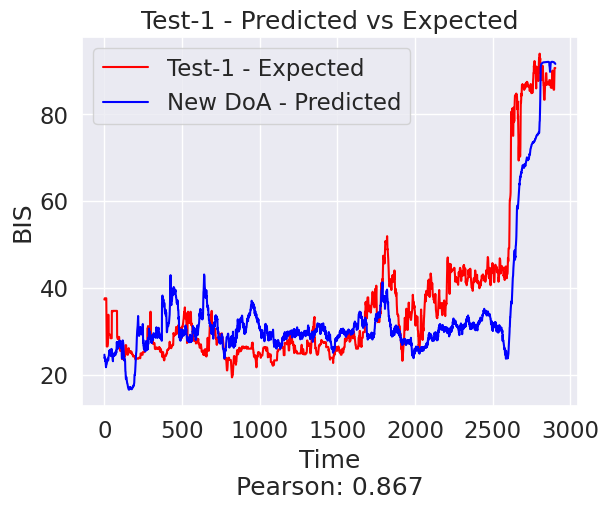


Fitting ANN model...
858/858 [==============================] - 1s 730us/step

Fitting SVM model...
86/86 [==============================] - 0s 811us/step
{'Test': 'Test-2', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8544175118549517, 'MSE': 76.5468003047584, 'MAE': 6.272841649348583, 'R2': 0.6355417595929113}


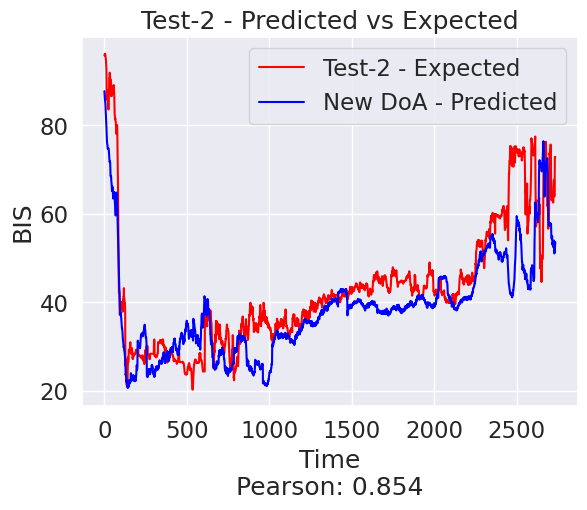


Fitting ANN model...
858/858 [==============================] - 1s 1ms/step

Fitting SVM model...
107/107 [==============================] - 0s 713us/step
{'Test': 'Test-3', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8077321675627879, 'MSE': 124.95119214006854, 'MAE': 9.390511505564445, 'R2': 0.593883632280133}


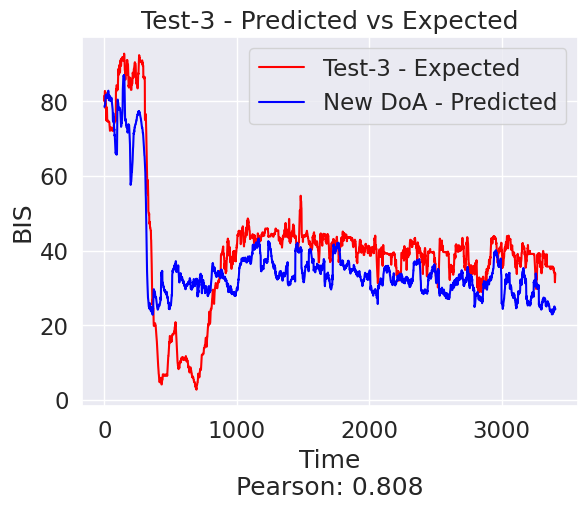


Fitting ANN model...
858/858 [==============================] - 1s 827us/step

Fitting SVM model...
105/105 [==============================] - 0s 815us/step
{'Test': 'Test-4', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.7618662555810175, 'MSE': 114.90061311402508, 'MAE': 8.006632449024277, 'R2': 0.5293177797624057}


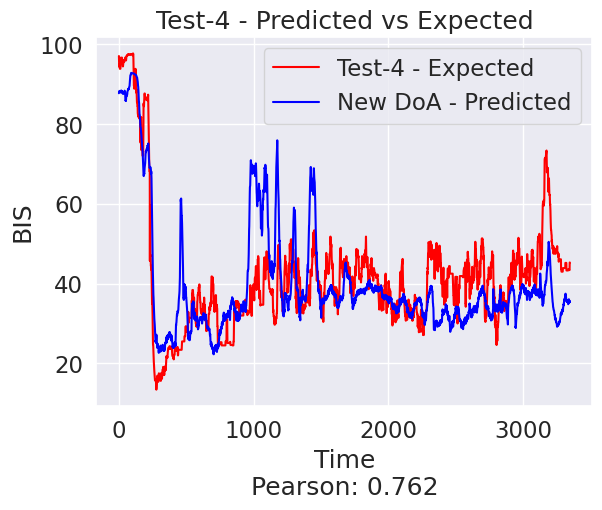


Fitting ANN model...
858/858 [==============================] - 1s 734us/step

Fitting SVM model...
88/88 [==============================] - 0s 841us/step
{'Test': 'Test-5', 'Method': 'Univariate', 'Features': ['x1', 'x2', 'x5', 'x7'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.954051580250496, 'MSE': 68.02897133495303, 'MAE': 7.314357952613454, 'R2': 0.8029062412684661}


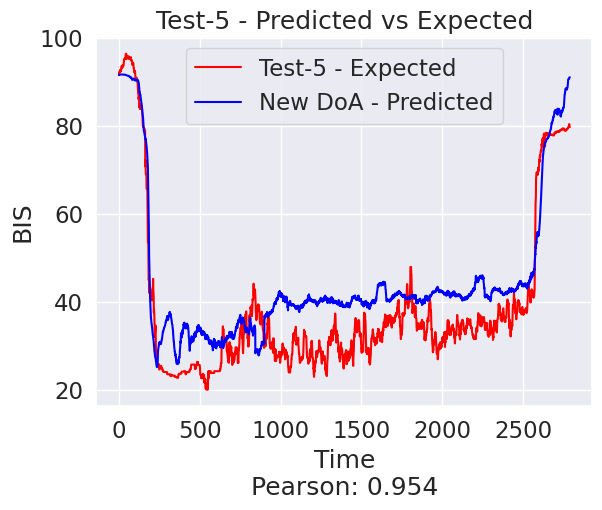

In [54]:
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']
## Univariate Feature Selection
for test in test_datasets:
    combined_ML(test, df_training_univ_fs, df_testing[test].drop('BIS', axis=1)[df_training_univ_fs_col.tolist()], df_training['BIS'], df_testing[test]['BIS'], 'Univariate', plotting=True)



### Training, testing and plottings using PCA features


Fitting ANN model...
858/858 [==============================] - 1s 672us/step

Fitting SVM model...
91/91 [==============================] - 0s 767us/step
{'Test': 'Test-1', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8670403400735492, 'MSE': 118.27232757642221, 'MAE': 9.371184011669914, 'R2': 0.6226818801118285}


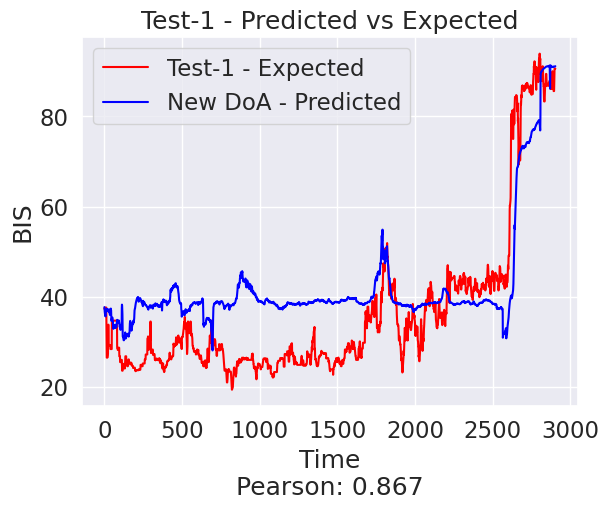


Fitting ANN model...
858/858 [==============================] - 1s 761us/step

Fitting SVM model...
86/86 [==============================] - 0s 710us/step
{'Test': 'Test-2', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.8882035179474695, 'MSE': 46.15820171864013, 'MAE': 4.848365296432983, 'R2': 0.7802293902324577}


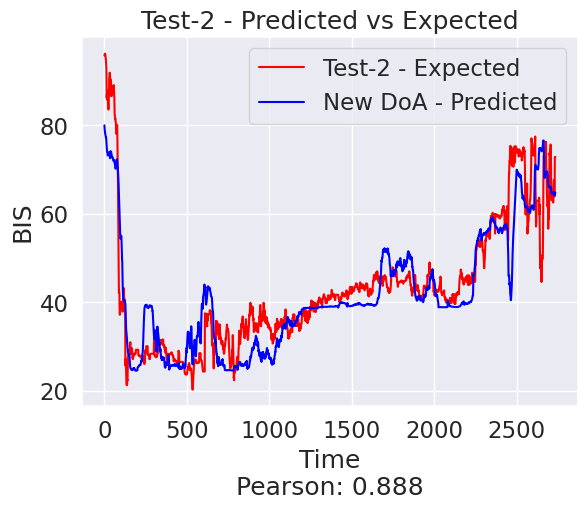


Fitting ANN model...
858/858 [==============================] - 1s 838us/step

Fitting SVM model...
107/107 [==============================] - 0s 1ms/step
{'Test': 'Test-3', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.6350864892895495, 'MSE': 187.3210942184934, 'MAE': 8.700652773410503, 'R2': 0.39116897503428816}


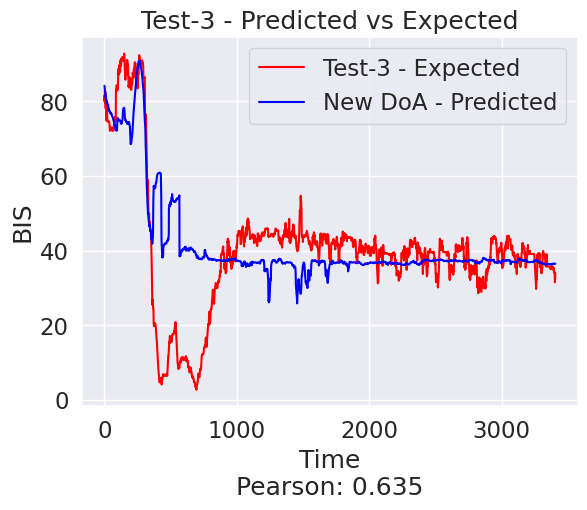


Fitting ANN model...
858/858 [==============================] - 1s 745us/step

Fitting SVM model...
105/105 [==============================] - 0s 940us/step
{'Test': 'Test-4', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.5800235301393019, 'MSE': 198.77186994700062, 'MAE': 11.099021302098713, 'R2': 0.18574511891779777}


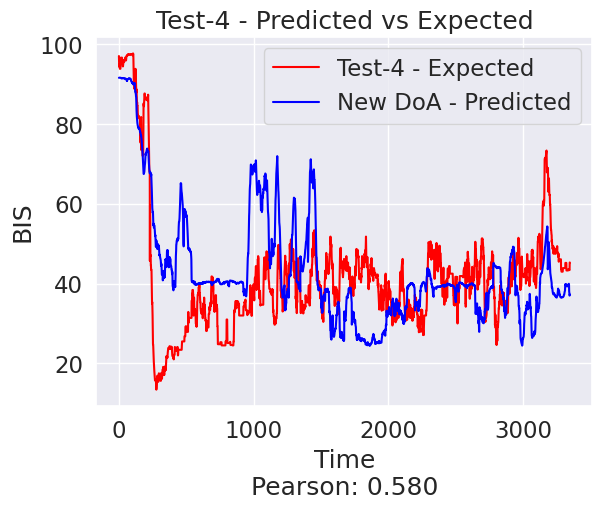


Fitting ANN model...
858/858 [==============================] - 1s 750us/step

Fitting SVM model...
88/88 [==============================] - 0s 803us/step
{'Test': 'Test-5', 'Method': 'PCA', 'Features': ['pca0', 'pca1'], 'ANN_first_h_layer': 6, 'ANN_second_h_layer': 12, 'Pearson': 0.7802717877280243, 'MSE': 179.32745031007647, 'MAE': 10.347695858020481, 'R2': 0.4804519231765074}


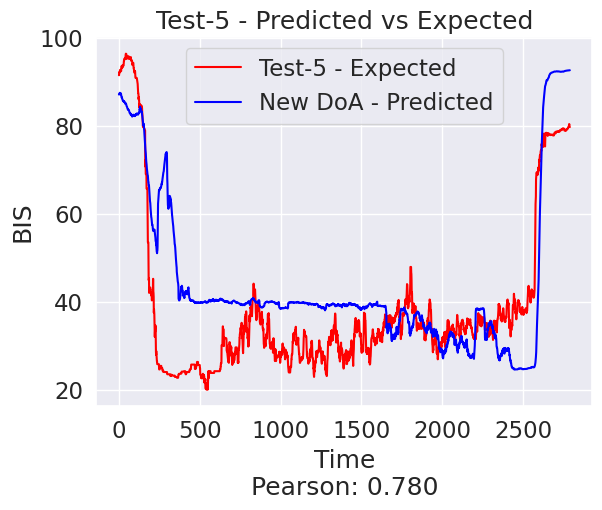

In [55]:
test_datasets = ['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5']
## PCA Feature extraction
for index_test, test in enumerate(test_datasets):
    combined_ML(test, pca_array_features[0], pca_array_features_test[f'{test}_2'], df_training['BIS'], df_testing[test]['BIS'], 'PCA', plotting=True)


